In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx].astype('float32').reshape(28, 28) / 255.0
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the MNIST data from an online source using fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data  # Features
y = mnist.target.astype('int64')  # Labels converted to integers

# Create train, val, test splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(0.2/0.9), random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create Dataset objects
trainset = MNISTDataset(X_train, y_train, transform=transform)
valset = MNISTDataset(X_val, y_val, transform=transform)
testset = MNISTDataset(X_test, y_test, transform=transform)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Verify the data shapes
for images, labels in trainloader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [5]:
class MLP(nn.Module):
    def __init__(self, layers_hidden):
        super(MLP, self).__init__()
        # layers_hidden is a list of layer sizes, for example: [784, something, 10]
        layers = []
        for i in range(len(layers_hidden) - 1):
            in_features = layers_hidden[i]
            out_features = layers_hidden[i+1]
            layers.append(nn.Linear(in_features, out_features))
            if i < len(layers_hidden) - 2:
                # Use SiLU activation for hidden layers (same as KAN base_activation)
                layers.append(nn.SiLU())
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [7]:
model = MLP([28*28, 28*28*2+1, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=1569, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1569, out_features=10, bias=True)
  )
)

In [9]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [11]:
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [13]:
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False
num_epochs = 20

for epoch in range(num_epochs):
    if early_stop:
        break

    # Train
    model.train()
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels).float().mean()
            epoch_train_loss += loss.item()
            epoch_train_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
    
    epoch_train_loss /= len(trainloader)
    epoch_train_accuracy /= len(trainloader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            val_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(output.argmax(dim=1).cpu().numpy())

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {epoch_train_loss}, Train Accuracy: {epoch_train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == patience:
        print("Early stopping!")
        early_stop = True

100%|██████████| 766/766 [00:06<00:00, 112.50it/s, accuracy=1, loss=0.0474, lr=0.001]    


Epoch 1, Train Loss: 0.29251412246570807, Train Accuracy: 0.9114311357702349, Val Loss: 0.17549298115108655, Val Accuracy: 0.9442066210045662


100%|██████████| 766/766 [00:06<00:00, 113.68it/s, accuracy=0.949, loss=0.275, lr=0.0008] 


Epoch 2, Train Loss: 0.11524324287239744, Train Accuracy: 0.9647666030702018, Val Loss: 0.10764859761983224, Val Accuracy: 0.9681792237442922


100%|██████████| 766/766 [00:06<00:00, 112.16it/s, accuracy=1, loss=0.0199, lr=0.00064]    


Epoch 3, Train Loss: 0.07345067966041245, Train Accuracy: 0.9765013054830287, Val Loss: 0.10442402382002777, Val Accuracy: 0.9691780821917808


100%|██████████| 766/766 [00:06<00:00, 113.21it/s, accuracy=1, loss=0.0155, lr=0.000512]    


Epoch 4, Train Loss: 0.05152668870359966, Train Accuracy: 0.983946638381201, Val Loss: 0.07592689444536352, Val Accuracy: 0.9777178851436806


100%|██████████| 766/766 [00:06<00:00, 114.18it/s, accuracy=0.949, loss=0.0694, lr=0.00041]


Epoch 5, Train Loss: 0.03575715377849926, Train Accuracy: 0.9885508719997057, Val Loss: 0.07374643214093733, Val Accuracy: 0.9786672374429224


100%|██████████| 766/766 [00:06<00:00, 115.64it/s, accuracy=1, loss=0.0292, lr=0.000328]    


Epoch 6, Train Loss: 0.024605443551297502, Train Accuracy: 0.9925342689295039, Val Loss: 0.0742893769612034, Val Accuracy: 0.9787385844748858


100%|██████████| 766/766 [00:06<00:00, 115.34it/s, accuracy=1, loss=0.00108, lr=0.000262]   


Epoch 7, Train Loss: 0.01753049603684358, Train Accuracy: 0.9949616514360313, Val Loss: 0.06640536960593922, Val Accuracy: 0.98087899543379


100%|██████████| 766/766 [00:06<00:00, 118.21it/s, accuracy=1, loss=0.00719, lr=0.00021]   


Epoch 8, Train Loss: 0.012462344484100685, Train Accuracy: 0.9968994778067886, Val Loss: 0.0639672676897629, Val Accuracy: 0.9832334474885844


100%|██████████| 766/766 [00:06<00:00, 117.68it/s, accuracy=1, loss=0.00847, lr=0.000168]   


Epoch 9, Train Loss: 0.008947182622481035, Train Accuracy: 0.9979805809399478, Val Loss: 0.05844315918863881, Val Accuracy: 0.9845890410958904


100%|██████████| 766/766 [00:06<00:00, 117.93it/s, accuracy=1, loss=0.000988, lr=0.000134]  


Epoch 10, Train Loss: 0.006720563216688791, Train Accuracy: 0.9988577023498695, Val Loss: 0.06094620228276192, Val Accuracy: 0.984232305936073


100%|██████████| 766/766 [00:06<00:00, 115.71it/s, accuracy=1, loss=0.0167, lr=0.000107]    


Epoch 11, Train Loss: 0.0051662562669928256, Train Accuracy: 0.9991840731070496, Val Loss: 0.05961978453483654, Val Accuracy: 0.984517694063927


100%|██████████| 766/766 [00:06<00:00, 118.18it/s, accuracy=1, loss=0.00235, lr=8.59e-5]   


Epoch 12, Train Loss: 0.003990378712780616, Train Accuracy: 0.9994288511749347, Val Loss: 0.061624544310797065, Val Accuracy: 0.9850884703196348
Early stopping!


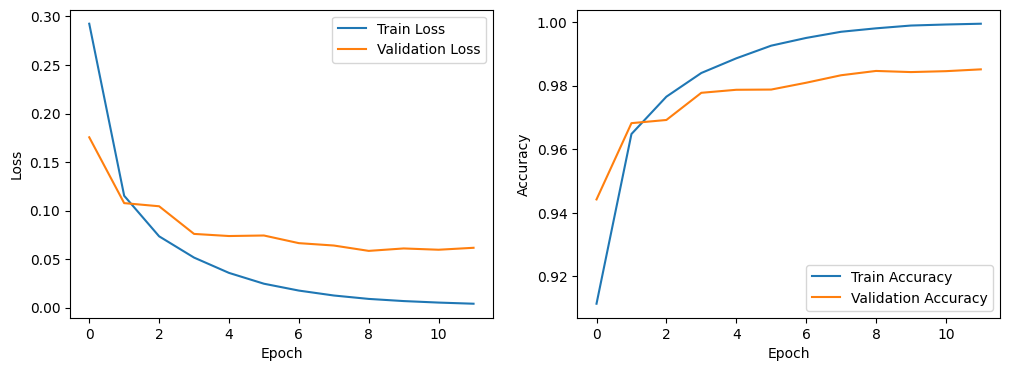

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

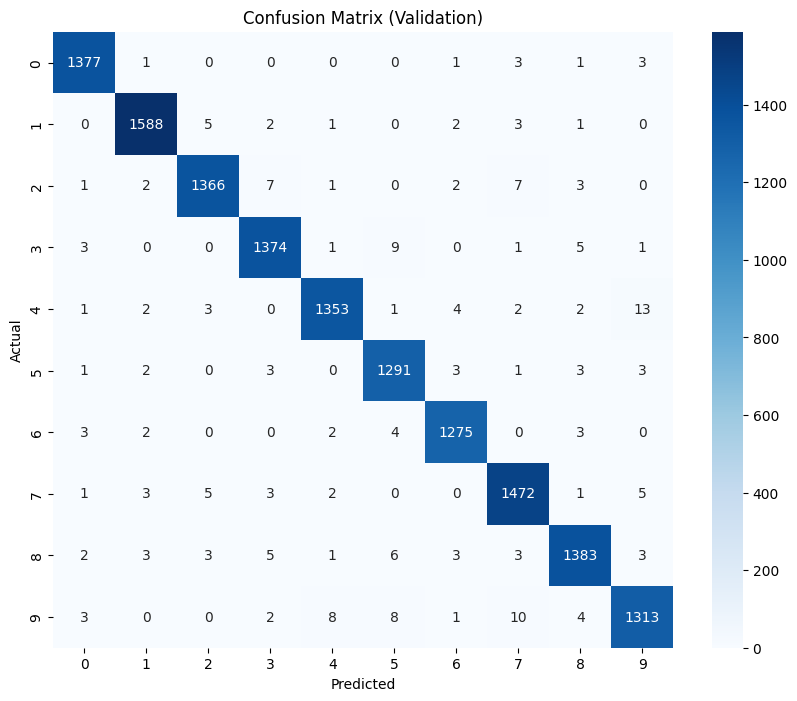

In [17]:
class_labels = np.arange(10)
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Validation)')
plt.show()

In [19]:
model.eval()
test_loss = 0
test_accuracy = 0
all_test_labels = []
all_test_preds = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        output = model(images)
        test_loss += criterion(output, labels).item()
        test_accuracy += (output.argmax(dim=1) == labels).float().mean().item()
        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(output.argmax(dim=1).cpu().numpy())

test_loss /= len(testloader)
test_accuracy /= len(testloader)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 0.06722492184403976, Test Accuracy: 0.9798768943006342


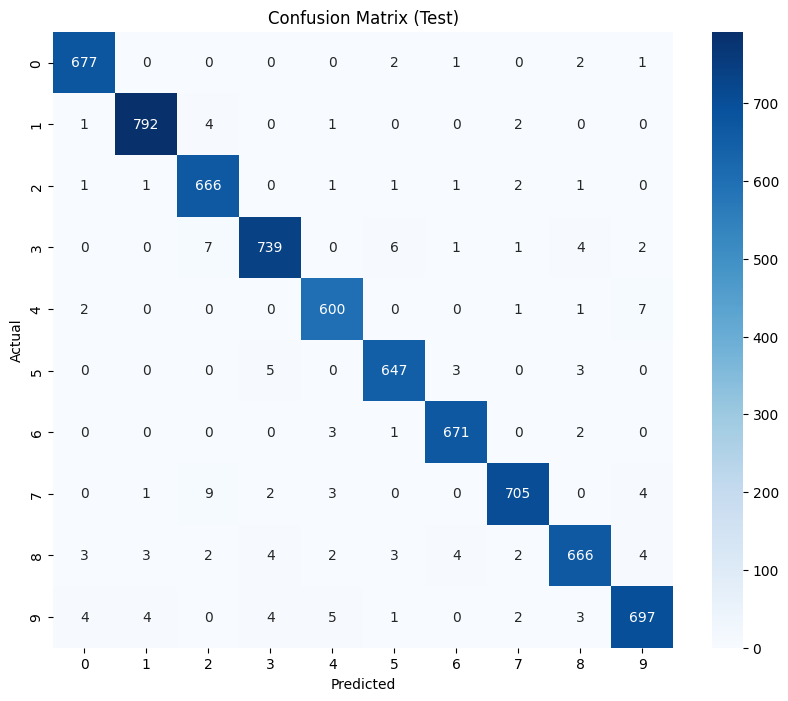

In [21]:
cm_test = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()